# Проект e-learning: вариант 2

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
assessments = pd.read_csv('assessments.csv')  #информация об оценках в тесте
courses = pd.read_csv('courses.csv')  #список предметов по семестрам
student_assessment = pd.read_csv('studentAssessment.csv')  #результаты тестов студентов
student_registration = pd.read_csv('studentRegistration.csv')   #информация о времени регистрации студента на курс

Объединение всех таблиц в один DataFrame:

In [3]:
df = student_assessment \
                    .merge(assessments, on ='id_assessment')\
                    .merge(student_registration, on =['code_presentation','code_module','id_student']) \
                    .merge(courses, on =['code_presentation','code_module'])

In [4]:
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration,module_presentation_length
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN,268
1,1753,11391,53,0,85.0,AAA,2013J,TMA,54.0,20.0,-159.0,NaN,268
2,1754,11391,115,0,80.0,AAA,2013J,TMA,117.0,20.0,-159.0,NaN,268
3,1755,11391,164,0,85.0,AAA,2013J,TMA,166.0,20.0,-159.0,NaN,268
4,1756,11391,212,0,82.0,AAA,2013J,TMA,215.0,30.0,-159.0,NaN,268


Описание данных:
- id_assessment - тест (идентификационный номер ассессмента);
- id_student - идентификационный номер студента;
- date_submitted - дата сдачи теста студентом, измеряемая как количество дней с начала семестра;
- is_banked - факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска);
- score - оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста;
- code_module - идентификационный код предмета,
- code_presentation - семестр,
- assessment_type - тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam);
- date - информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль);
- weight - вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%;
- date_registration - дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала);
- date_unregistration - дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым;
- module_presentation_length - продолжительность семестра в днях.

### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

Создается столбец, в котором будет указано, сдан тест успешно или нет. Успешная сдача теста - более 40 баллов:

In [5]:
df['is_successful'] = df['score'] > 40

Далее отбираются строки с типом теста "экзамен" и значением в столбце 'is_successful' равное True. После группировки по id студента отбираются те, у кого число курсов ('code_mod_count') равно одному:

In [9]:
only_one_course = df \
                    .query('assessment_type=="Exam" & is_successful') \
                    .groupby('id_student', as_index = False).agg(code_mod_count=('code_module','nunique')) \
                    .query('code_mod_count==1') \
                    .shape[0]
only_one_course

3708

Успешно сдали только один курс 3708 студентов. Тогда процент тех студенов, кто успешно сдал только один курс: 

In [10]:
round(only_one_course / df.id_student.nunique() * 100, 2)

15.87

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.

(завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен)

In [14]:
df \
    .query('assessment_type == "Exam"') \
    .groupby(['code_module','id_assessment']).agg(completion=('is_successful','mean')) \
    .sort_values('completion')

completion
code_module id_assessment            
DDD         25340            0.794020
CCC         24299            0.851884
DDD         25368            0.868421
CCC         24290            0.870147
DDD         25354            0.884298
            25361            0.912214

Самая высокая завершаемость у экзамена 25361 предмета DDD, самая низкая - у экзамена 25340 также предмета DDD.

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

Сначала среди всех успешных попыток сдать экзамен выбирается последняя (максимальная) дата сдачи 'date_submitted'. 

Далее полученый датафрейм группируется только по коду предмета и подсчитывается средний срок сдачи.

In [27]:
df \
    .query('assessment_type == "Exam" & is_successful') \
    .groupby(['id_student','id_assessment','code_module'], as_index=False).agg({'date_submitted':'max'}) \
    .groupby('code_module').agg({'date_submitted':'mean'})

,date_submitted
code_module,
CCC,239.341033
DDD,238.020478


Средние сроки сдачи экзаменов по предметам DDD и CCC отличаются незначительно.

### 4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).

In [35]:
df.groupby('code_module').agg({'date_registration':'count'}).sort_values('date_registration',ascending=False).head(3)

,date_registration
code_module,
FFF,54815
BBB,43032
DDD,30859


Больше всего регистраций на курсы FFF, BBB и DDD.

In [41]:
df.groupby('code_module').agg({'date_unregistration':'count'}).sort_values('date_unregistration', ascending = False).head(3)

,date_unregistration
code_module,
DDD,3523
FFF,3397
BBB,2693


Наибольшее количество отмен регистраций у тех же курсов, что и в топ-3 по количеству регистраций. Можно посчитать отток как процент студентов, покинувших курс:

In [48]:
df_reg = df.groupby('code_module').agg({'date_unregistration':'count','date_registration':'count'})
df_reg['churn'] = round(df_reg.date_unregistration / df_reg.date_registration*100, 2)
df_reg.sort_values('churn', ascending = False).head(3)

,date_unregistration,date_registration,churn
code_module,,,
CCC,2531,18939,13.36
DDD,3523,30859,11.42
AAA,220,3149,6.99


Топ-3 курса по оттоку студентов - ССС, DDD и AAA.

### 5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

В данных представлена информация для 2-х семестров (B и J) в период с 2013 по 2014 гг. 

Функция для построения когортного анализа принимает на вход: 
- датафрейм, 
- название столбца, по которому необходимо посчитать показатели,
- обозначение функции, применяемой к столбцу (по умолчанию - среднее).

Возвращает функция сводную таблицу с необходимыми показателями по семестрам B и J.

In [7]:
def cohort_analysis(data, column, func='mean'):
    data['year'] = data['code_presentation'].str[:4]
    data['semester'] = data['code_presentation'].str[-1]
    data_cohort = data.pivot_table(index='year',columns='semester',values=column,aggfunc=func)
    return data_cohort

In [15]:
cohort_analysis(df.query('assessment_type == "Exam"'),'is_successful','mean')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


semester,B,J
year,,
2013,0.79402,0.884298
2014,0.88749,0.859301


В 2013-2014 гг. семестр с самой высокой завершаемостью - 2014B.

In [16]:
cohort_analysis(df.query('assessment_type == "Exam" & is_successful'),'date_submitted','mean')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


semester,B,J
year,,
2013,230.167364,239.514019
2014,233.008865,243.680220


В 2013-2014 гг. семестр с самыми долгими средними сроками сдачи курсов - 2014J.

### 6. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

В адаптированной кластеризации выбраны следующие метрики: 
- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен. 

Для того, чтобы определить количество ступеней, на которые будет разделен каждый показатель, а также границы ступеней, нужно посмотреть на распределение величин.

На кластеры подразделяются только те студенты, которые хотя бы раз сдавали экзамены, то есть студенты курсов CCC и DDD:

In [59]:
cm_exam = ['CCC','DDD']

In [60]:
df.query('code_module not in @cm_exam & assessment_type=="Exam"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration,module_presentation_length,is_successful


Распределение среднего времени сдачи одного экзамена:

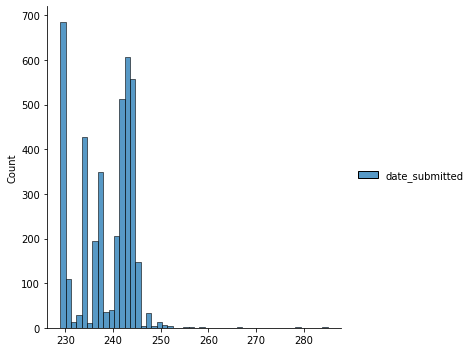

In [19]:
sns.displot(data=df.query('assessment_type == "Exam" & is_successful')
            .groupby('id_student')
            .agg({'date_submitted':'mean'}));

Большинство студентов успешно сдают экзамены в период между 240-250 днями с начала семестра. 

Тогда границы для показателя R - среднее время сдачи одного экзамена: 
- 1 - до 240 дня, 
- 2 - в период 240-250 дней, 
- 3 - 250 дней и более.

Распределение завершаемости курсов:

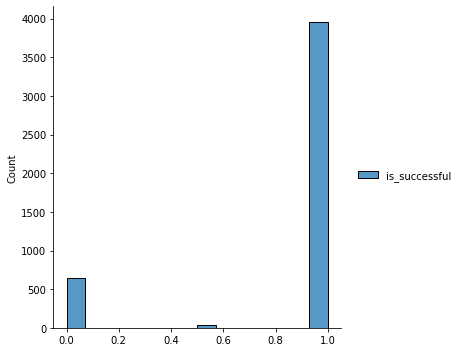

In [21]:
sns.displot(data = df.query('assessment_type == "Exam"')
            .groupby('id_student')
            .agg({'is_successful':'mean'}))

Для завершаемости курсов для каждого студента есть три варианта: 
- 0 - не сдал ни один экзамен, 
- 0,5 - сдал один экзамен из двух (ССС и DDD), либо из двух попыток сдать один экзамен только одна была удачная,
- 1 - все попытки сдачи экзаменов были удачные.

Поэтому при разделении показателя F (завершаемость курсов) выбирается три ступени: 
- 1 - завершаемость равна 1,
- 2 - завершаемость равна 0,5,
- 3 - завершаемость равна 0.

Распределение средних баллов за экзамены:

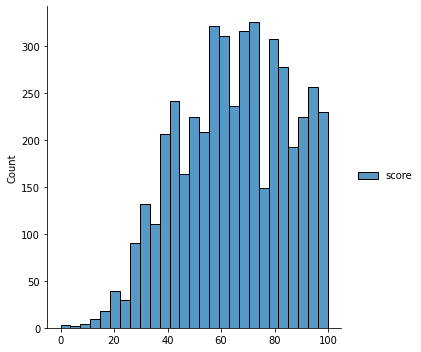

In [42]:
sns.displot(data=df.query('assessment_type == "Exam"')
            .groupby('id_student')
            .agg({'score':'mean'}))

Для показателя M выбираются границы:
- 1 - средний балл от 80 до 100 (отлично),
- 2 - балл от 40 до 80 (хорошо),
- 3 - балл ниже 40.

Далее студенты распределяется по кластерам в зависимости от кода RFM.

In [6]:
students = df.query('assessment_type == "Exam"') \
            .groupby('id_student', as_index=False) \
            .agg({'score':'mean','is_successful':'mean'}) #для каждого студента - средний балл и завершаемость курсов

In [7]:
students = students.merge(df.query('assessment_type == "Exam" & is_successful') #учитываются только успещные попытки
                            .groupby('id_student', as_index=False)
                            .agg({'date_submitted':'mean'}), 
                            on = 'id_student', 
                            how = 'left')   #к таблице добавляются средние сроки сдачи экзаменов

In [8]:
students.head() #Nan в колонке date_submitted означает, что успешных попыток сдачи экзаменов не было

,id_student,score,is_successful,date_submitted
0,23698,80.0,1.0,243.0
1,24213,58.0,1.0,236.0
2,27116,96.0,1.0,243.0
3,28046,40.0,0.0,NaN
4,28787,44.0,1.0,243.0


In [12]:
r1 = 240 #задаются разделители показателей, кроме показателя F
r2 = 250
m1 = 40
m2 = 80

In [18]:
def rfm_cluster(row): 
    if row['date_submitted'] < r1:
        r = '1'
    elif row['date_submitted'] > r2:
        r = '3'
    else:
        r = '2'
        
    if row['score'] < m1:
        m = '3'
    elif row['score'] >= m2:
        m = '1'
    else:
        m = '2'
        
    if row['is_successful'] == 1:
        f = '1'
    elif row['is_successful'] == 0:
        f = '3'
    else:
        f = '2'
    return r+f+m

In [19]:
students['rfm'] = students.apply(rfm_cluster, axis = 1)

In [23]:
students.rfm.nunique()

12

Из возможных 27 кластеров студенты распределились по 12-ти.